In [4]:
# Loading all the needed Packages
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Import classes from Class.py
from Data_handling import *
from Class import *

import time

In [5]:
## PARAMETERS DEFINITION

# Time
H = 24          # Hours in a day
D = 5           # Typical days in a year
Y = 30          # Years of the investment timeline
N = H*D*Y       # Number of hours in the investment timeline    


# Number of loads and generators
N_dem = len(Dem[0,:])       # Number of loads
N_gen_E = len(Gen_E_OpCost)   # Number of existing generators
N_gen_N = len(Gen_N_OpCost)   # Number of new generators
N_zone = len(Trans_Z_Connected_To_Z)     # Number of zones
N_line = len(Trans_Line_From_Z)   # Number of transmission lines


# Hyperparameters
B = 3000000000   # Budget for the investment problem
R = 73 # Conversion rate


In [6]:
## CREATE THE PARAMETERS AND DATA OBJECTS
ParametersObj = Parameters(H, D, Y, N, N_dem, N_gen_E, N_gen_N, N_zone, N_line, B, R, N_S, N_S_train, N_S_test, max_deviation)
DataObj = InputData(Dem, Uti, Load_Z, Gen_E_OpCost, Gen_N_OpCost, Gen_N_MaxInvCap, Gen_E_Cap, Gen_N_InvCost, Gen_E_Tech, Gen_N_Tech, Gen_E_Z, Gen_N_Z, Gen_E_OpCap, Gen_N_OpCap, Trans_React, Trans_Cap, Trans_Line_From_Z, Trans_Line_To_Z, Trans_Z_Connected_To_Z,Gen_N_Data_scenarios,Gen_N_OpCost_scenarios, Gen_N_Data_scenarios_train, Gen_N_OpCost_scenarios_train, Gen_N_Data_scenarios_test, Gen_N_OpCost_scenarios_test)

# Model 1: Sequential optimization of Dispatch problem and Investment problem

### 1) Market Clearing

In [7]:
# Run the Market Clearing Problem
MarketClearing1 = MarketClearingModel1(ParametersObj, DataObj)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-07


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 140400 rows, 126000 columns and 270000 nonzeros
Model fingerprint: 0x4c1471a4
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+01, 1e+03]
  Bounds range     [1e+03, 1e+03]
  RHS range        [4e-01, 1e+03]
Presolve removed 134239 rows and 109069 columns
Presolve time: 0.32s
Presolved: 6161 rows, 16931 columns, 19670 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.739e+03
 Factor NZ  : 8.900e+03 (roughly 10 MB of memory)
 Factor Ops : 1.438e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pr

## Test & Train models

In [8]:
# Run the Test_and_Train_model for Robust, Chance and CVaR, for train and test sets, and store the results in lists
Train_Robust = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Robust')
Train_Chance = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Chance', epsilon=0.2)
Train_CVaR = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='CVaR', Beta=0.5, Alpha=0.95)
Train_Deterministic = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Deterministic')
Test_Robust = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Robust', Type='Test', Targets=Train_Robust.res.P_N)
Test_Chance = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Chance', Type='Test', Targets=Train_Chance.res.P_N, epsilon=1)
Test_CVaR = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='CVaR', Type='Test', Targets=Train_CVaR.res.P_N)
Test_Deterministic = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Deterministic', Type='Test', Targets=Train_Deterministic.res.P_N)

Set parameter Presolve to value 2
Set parameter Threads to value 4
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Optimize a model with 1921256 rows, 1920016 columns and 3738256 nonzeros
Model fingerprint: 0xf68ba751
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [4e-02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1921103 rows and 1920000 columns
Presolve time: 1.77s
Presolved: 153 rows, 16 columns, 2448 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8931600e+14   3.377476e+08   0.000000e+00      2s
       6    3.2575314e+13   0.000000e+00   0.000000e+00      3

# Displaying System Data

Budget: 3000000000


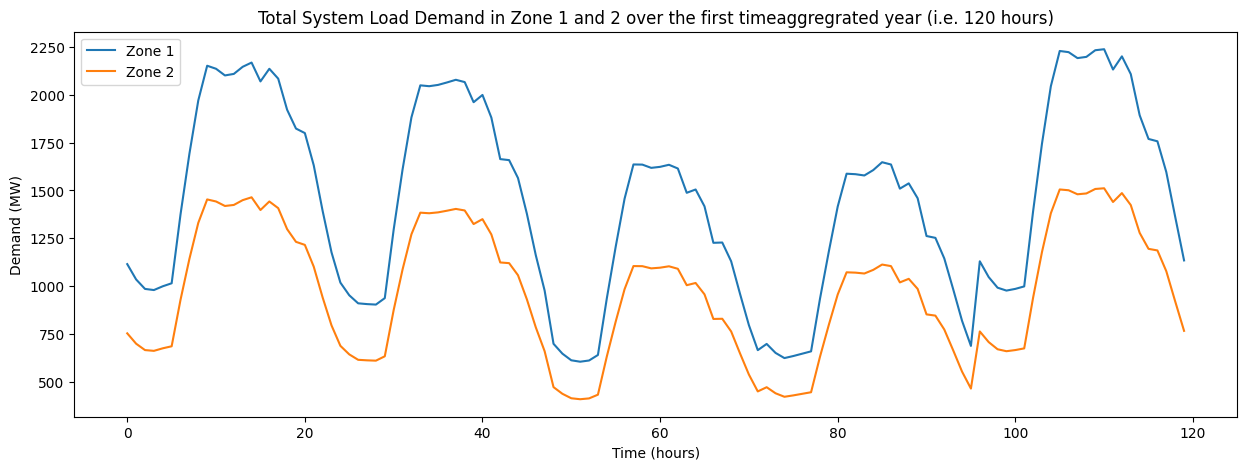

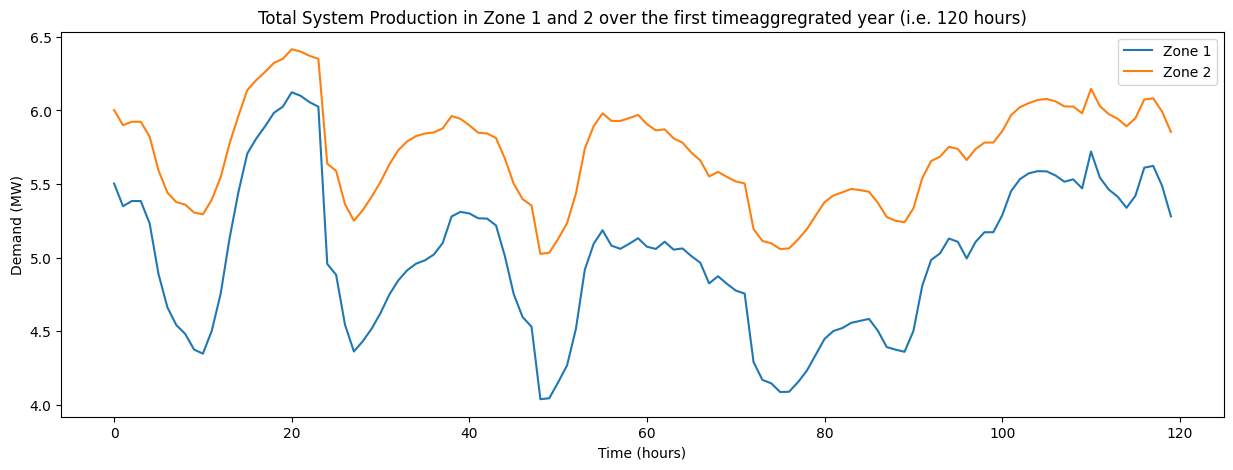

In [9]:
#Print the core results
#Print the budget
print('Budget:', Train_Robust.res.budget)

# Plot the demand data for the first 120 hours in zone 1 by summing the demand of all uneven loads
plt.figure(figsize=(15, 5))
plt.plot(Train_Robust.res.Demand[:120, ::2].sum(axis=1), label='Zone 1')
plt.plot(Train_Robust.res.Demand[:120, 1::2].sum(axis=1), label='Zone 2')
plt.title('Total System Load Demand in Zone 1 and 2 over the first timeaggregrated year (i.e. 120 hours)')
plt.xlabel('Time (hours)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()

# Plot the demand data for the first 120 hours in zone 1 by summing the demand of all uneven loads
plt.figure(figsize=(15, 5))
plt.plot(Train_Robust.res.Generation[:120, ::2].sum(axis=1), label='Zone 1')
plt.plot(Train_Robust.res.Generation[:120, 1::2].sum(axis=1), label='Zone 2')
plt.title('Total System Production in Zone 1 and 2 over the first timeaggregrated year (i.e. 120 hours)')
plt.xlabel('Time (hours)')
plt.ylabel('Demand (MW)')
plt.legend()
plt.show()


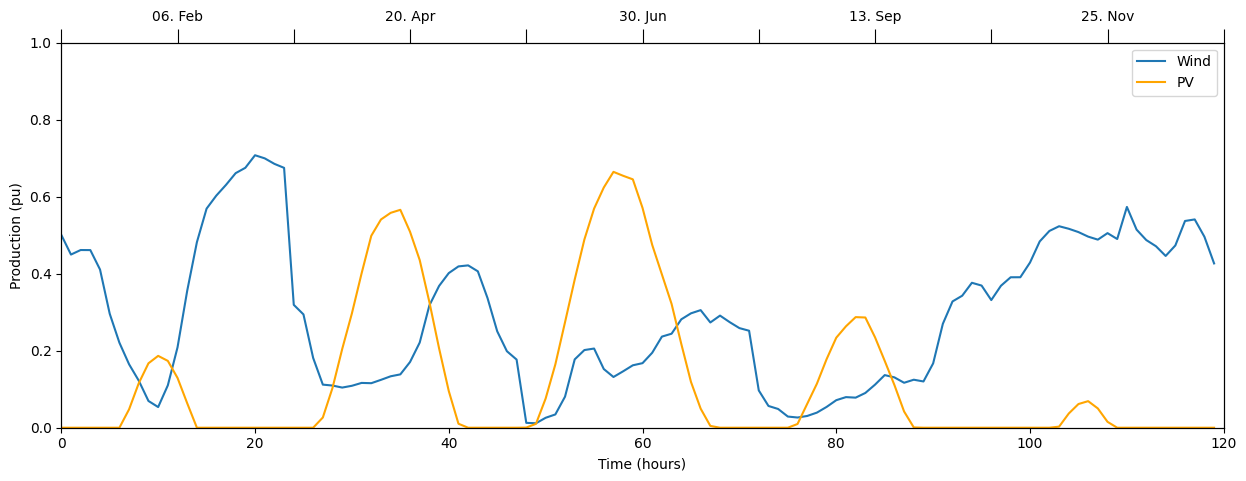

In [10]:
# Plot OpCap for Wind Farms and PV Farms in the first 120 hours
fig, ax1 = plt.subplots(figsize=(15, 5))

# Primary x-axis
ax1.plot(Train_Robust.res.Generation[:120, 7], label='Wind')
ax1.plot(Train_Robust.res.Generation[:120, 9], label='PV', color='orange')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Production (pu)')
ax1.set_ylim(0, 1)
ax1.set_xlim(0, 120)
ax1.legend()

# Secondary x-axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks([0,12,24,36,48, 60,72, 84,96, 108,120], minor=False)
ax2.tick_params(axis='x', which='both', length=6)  # Set default tick length
ax2.tick_params(axis='x', which='major', length=10)  # Set major tick length
ax2.set_xticklabels(['','06. Feb','','20. Apr','','30. Jun','','13. Sep','','25. Nov',''])

# Make every second tickmark larger, starting with the first one
for i, tick in enumerate(ax2.get_xticklabels()):
    if i % 2 == 0:
        tick.set_fontsize(12)
        tick.set_fontweight('bold')

plt.show()


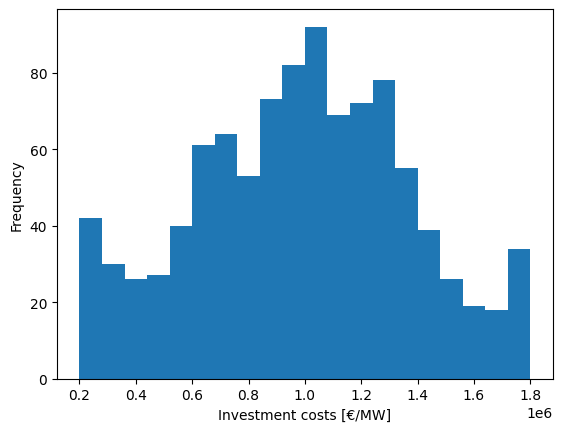

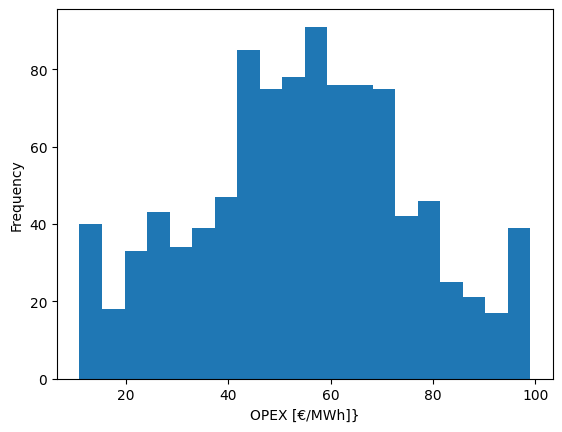

In [11]:
#print the fith row of Gen_N_Data_scenarios_train
#print(DataObj.Gen_N_Data_scenarios_train[5,:])

#create histogram of the DataObj.Gen_N_Data_scenarios_train[5,:]
plt.hist(DataObj.Gen_N_Data_scenarios_train[5,:], bins=20,)
#plt.title('Histogram of the investment costs for the wind generators')
plt.xlabel('Investment costs [€/MW]')
plt.ylabel('Frequency')
plt.show()


#create histogram of the DataObj.Gen_N_Data_scenarios_train[5,:]
plt.hist(DataObj.Gen_N_OpCost_scenarios_train[4,:], bins=20)
#plt.title('Histogram of the OPEX costs for coal power plant')
plt.xlabel('OPEX [€/MWh]}')
plt.ylabel('Frequency')
plt.show()


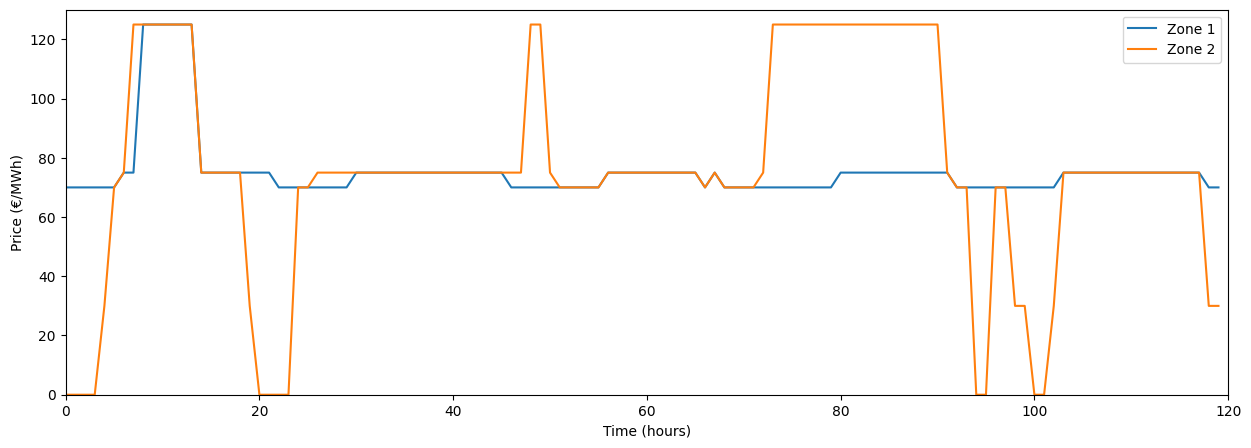

Average Price in Zone 1: 75.41666666666667
Average Price in Zone 2: 75.41666666666667
Standard Deviation of the Price in Zone 1: 11.678165601699966
Standard Deviation of the Price in Zone 2: 35.45374151080314
5th percentile of the Price in Zone 1: 70.0
5th percentile of the Price in Zone 2: -0.0
95th percentile of the Price in Zone 1: 77.49999999999986
95th percentile of the Price in Zone 2: 125.0


In [12]:
#Drop all columns apart from Price Zone 1 and 2
ZonalPrices = MarketClearing1.res.df[['Price Zone 0','Price Zone 1']].head(120)

#Plot the zonal prices
plt.figure(figsize=(15, 5))
plt.plot(ZonalPrices)
#plt.title('Zonal Prices in Zone 1 and 2 over the first timeaggregrated year (i.e. 120 hours)')
plt.xlabel('Time (hours)')
plt.ylabel('Price (€/MWh)')
plt.legend(['Zone 1', 'Zone 2'])
plt.xlim(0, 120)
plt.ylim(0, 130)
plt.show()


#Print the average Price in Zone 1 and 2
print('Average Price in Zone 1:', ZonalPrices['Price Zone 0'].mean())
print('Average Price in Zone 2:', ZonalPrices['Price Zone 1'].mean())

#Print the standard deviation of the prices in Zone 1 and 2
print('Standard Deviation of the Price in Zone 1:', ZonalPrices['Price Zone 0'].std())
print('Standard Deviation of the Price in Zone 2:', ZonalPrices['Price Zone 1'].std())

#Print the 5th and 95th percentile of the prices in Zone 1 and 2
print('5th percentile of the Price in Zone 1:', ZonalPrices['Price Zone 0'].quantile(0.05))
print('5th percentile of the Price in Zone 2:', ZonalPrices['Price Zone 1'].quantile(0.05))
print('95th percentile of the Price in Zone 1:', ZonalPrices['Price Zone 0'].quantile(0.95))
print('95th percentile of the Price in Zone 2:', ZonalPrices['Price Zone 1'].quantile(0.95))    


# Displaying the relevant results for each model

## Deterministic

In [13]:
#Displaying the invested capacity  
Train_Deterministic.res.df

,Technology,Invested Capacity (MW)
0,Coal,400.000000
1,Coal,62.369221
2,Coal,400.000000
3,Gas,0.000000
4,Coal,400.000000
5,Wind,400.000000
6,Wind,400.000000
7,PV,400.000000
8,Gas,0.000000
9,Coal,0.000000


In [14]:
#Display the remaining budget
Train_Deterministic.res.rem_budget

np.float64(0.0)

In [15]:
#Display the objective values
Train_Deterministic.res.objective_values

[np.float64(37.745338664620796)]

## Robust

In [16]:
#Displaying the invested capacity 
Train_Robust.res.df


,Technology,Invested Capacity (MW)
0,Coal,0.000000
1,Coal,0.000000
2,Coal,400.000000
3,Gas,400.000000
4,Coal,0.000000
5,Wind,400.000000
6,Wind,400.000000
7,PV,400.000000
8,Gas,0.000000
9,Coal,0.000000


In [17]:
#Display the remaining budget
Train_Robust.res.rem_budget

np.float64(808968969.3418698)

In [18]:
#Display expected profit
np.mean(Train_Robust.res.objective_values)

np.float64(33.383473807853484)

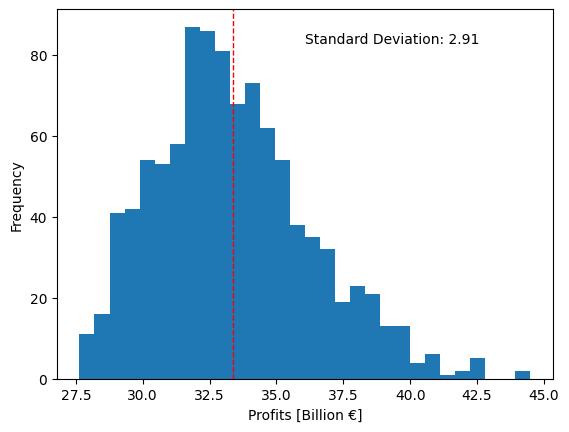

In [19]:
#Create a histogram of the objective values
plt.hist(Train_Robust.res.objective_values, bins=30)
plt.axvline(np.mean(Train_Robust.res.objective_values), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Profits [Billion €]')
plt.ylabel('Frequency')
#plt.title('Histogram of the Objective Values')
plt.text(0.5, 0.9, f'Standard Deviation: {Train_Robust.res.standard_deviation.round(2)}', horizontalalignment='left', verticalalignment='bottom', transform=plt.gca().transAxes)
plt.show()


## Chance Constraint

In [20]:
#Displaying the invested capacity 
Train_Chance.res.df

,Technology,Invested Capacity (MW)
0,Coal,400.000000
1,Coal,0.000000
2,Coal,400.000000
3,Gas,400.000000
4,Coal,90.144691
5,Wind,400.000000
6,Wind,400.000000
7,PV,400.000000
8,Gas,0.000000
9,Coal,0.000000


In [21]:
#Display the remaining budget
Train_Chance.res.rem_budget

np.float64(217779623.60291672)

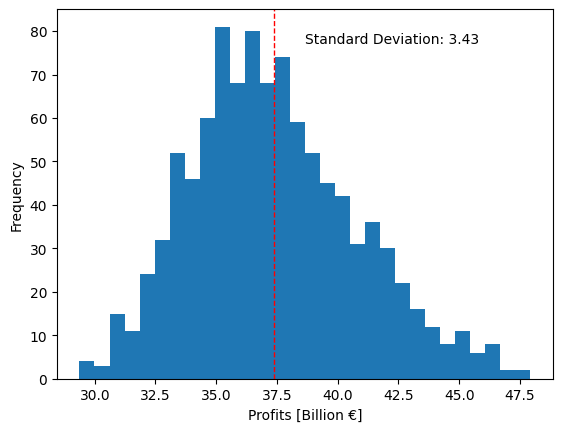

In [22]:
#Create a histogram of the objective values
plt.hist(Train_Chance.res.objective_values, bins=30)
plt.axvline(np.mean(Train_Chance.res.objective_values), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Profits [Billion €]')
plt.ylabel('Frequency')
#plt.title('Histogram of the Objective Values')
plt.text(0.5, 0.9, f'Standard Deviation: {Train_Chance.res.standard_deviation.round(2)}', horizontalalignment='left', verticalalignment='bottom', transform=plt.gca().transAxes)

plt.show()

## CVaR

In [23]:
#Displaying the invested capacity 
Train_CVaR.res.df

,Technology,Invested Capacity (MW)
0,Coal,54.650393
1,Coal,36.702500
2,Coal,58.289700
3,Gas,133.747074
4,Coal,36.397450
5,Wind,400.000000
6,Wind,400.000000
7,PV,400.000000
8,Gas,0.000000
9,Coal,0.000000


In [24]:
#Display the remaining budget
Train_CVaR.res.rem_budget

np.float64(808968969.3418698)

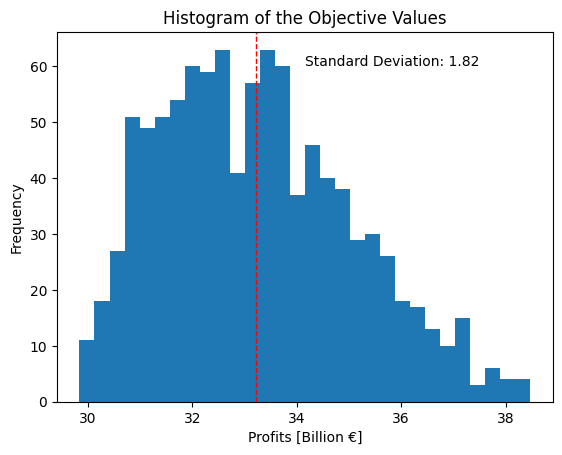

In [25]:
#Create a histogram of the objective values
plt.hist(Train_CVaR.res.objective_values, bins=30)
plt.axvline(np.mean(Train_CVaR.res.objective_values), color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Profits [Billion €]')
plt.ylabel('Frequency')
plt.title('Histogram of the Objective Values')
plt.text(0.5, 0.9, f'Standard Deviation: {Train_CVaR.res.standard_deviation.round(2)}', horizontalalignment='left', verticalalignment='bottom', transform=plt.gca().transAxes)
plt.show()

In [26]:
# Loop over Beta and run the model
Beta_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
Results_CVaR = []
Results_Expected_rev = []
for beta in Beta_values:
    Train_CVaR_Beta = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='CVaR', Beta=beta, Alpha=0.95)
    Results_CVaR.append(Train_CVaR_Beta.res.CVaR)
    Results_Expected_rev.append(Train_CVaR_Beta.res.Expected_Result)

Set parameter Presolve to value 2
Set parameter Threads to value 4
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Optimize a model with 1922256 rows, 1921017 columns and 5628256 nonzeros
Model fingerprint: 0x5d1f17ee
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [4e-05, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 1922103 rows and 1921001 columns
Presolve time: 2.28s
Presolved: 153 rows, 16 columns, 2448 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8931600e+11   3.377476e+08   0.000000e+00      2s
Extra simplex iterations after uncrush: 1
       7    3.257531

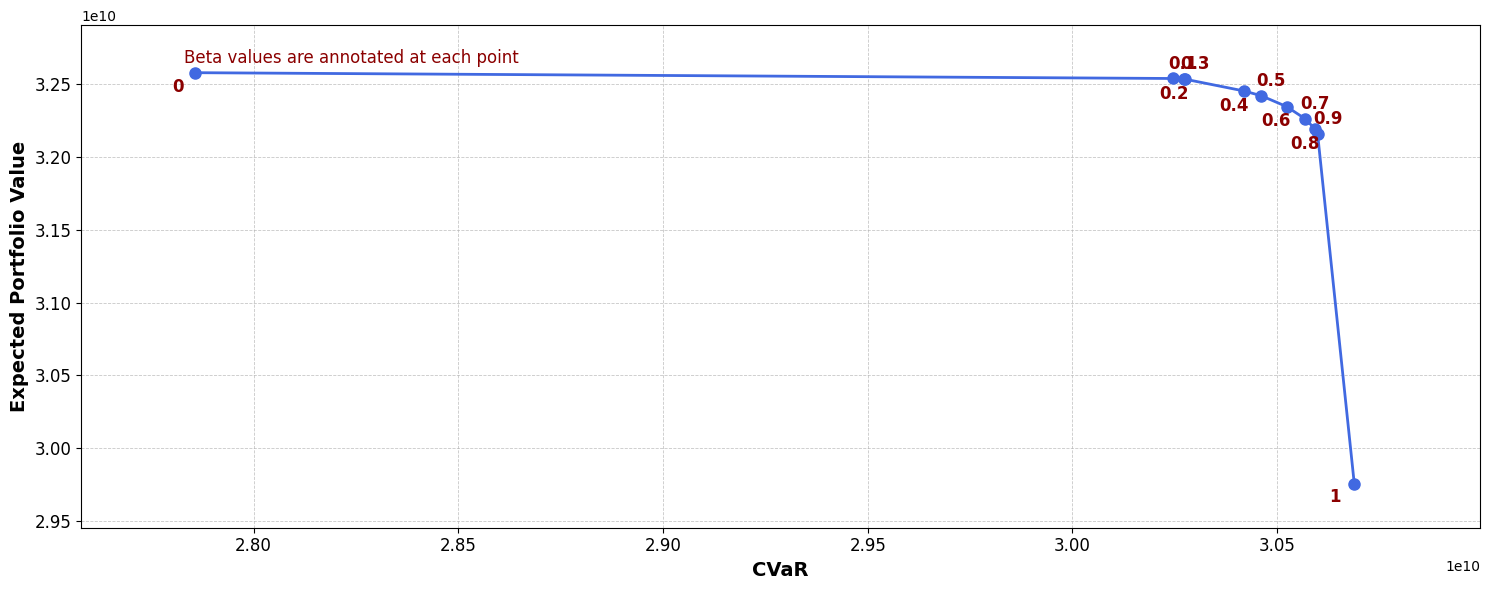

In [27]:
## PLOT THE RESULTS
plt.figure(figsize=(15, 6))  # Normal-sized dimensions

# Plot with consistent scaling for both axes
plt.plot(
    Results_CVaR, Results_Expected_rev, 
    marker='o', color='royalblue', linestyle='-', linewidth=2, markersize=8, label='Data Points'
)

# Set axis labels and title with professional formatting
plt.xlabel('CVaR', fontsize=14, fontweight='bold')
plt.ylabel('Expected Portfolio Value', fontsize=14, fontweight='bold')
#plt.title('Expected Portfolio Value vs. CVaR', fontsize=14, fontweight='bold')

#Set the tick marks to font size 12
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)	

# Annotate each point with its beta value
for i, beta in enumerate(Beta_values):
    if i % 2 == 0:
        plt.text(
            Results_CVaR[i] - (0.002*Results_CVaR[i]), Results_Expected_rev[i] - (0.005 * Results_Expected_rev[i]), 
            f'{beta}', fontsize=12, color='darkred', fontweight='bold',
            ha='left', va='bottom', bbox=dict(facecolor='none', edgecolor='none', alpha=0.8)
        )
    else:
        plt.text(
            Results_CVaR[i] + (0.002*Results_CVaR[i]), Results_Expected_rev[i] + (0.005 * Results_Expected_rev[i]), 
            f'{beta}', fontsize=12, color='darkred', fontweight='bold',
            ha='right', va='top', bbox=dict(facecolor='none', edgecolor='none', alpha=0.8)
        )

# Gridlines for clarity
plt.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.7)

# Adjusting axis limits for balanced visual spacing
plt.xlim(min(Results_CVaR) * 0.99, max(Results_CVaR) * 1.01)
plt.ylim(min(Results_Expected_rev) * 0.99, max(Results_Expected_rev) * 1.01)

# Add legend as a caption-like explanation
plt.text(
    min(Results_CVaR)* 0.999, max(Results_Expected_rev) * 1.002, 
    'Beta values are annotated at each point', fontsize=12, color='darkred'
)

# Tight layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()




# Comparing Results from all models

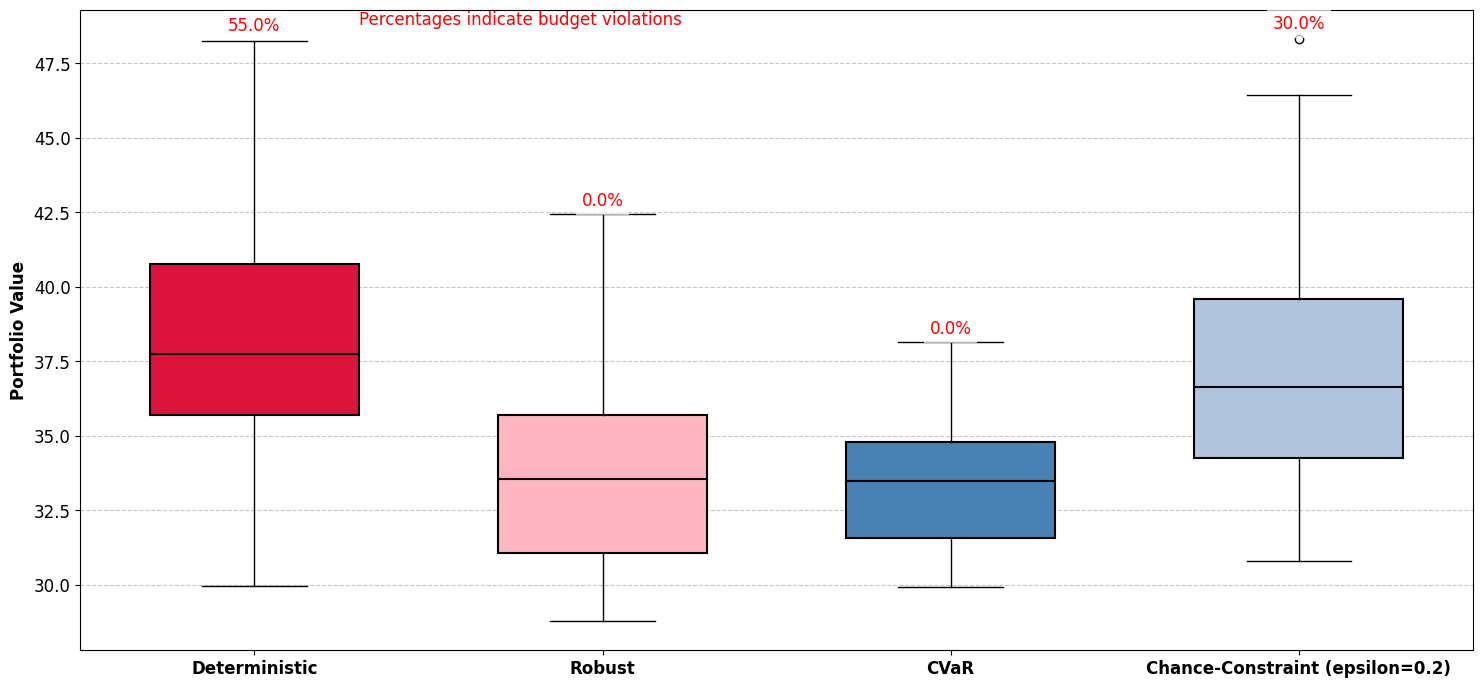

In [28]:
## PLOT THE RESULTS

# Data
objective_values = [
    #Train_Deterministic.res.objective_values, 
    Test_Deterministic.res.objective_values,
    #Train_Robust.res.objective_values, 
    Test_Robust.res.objective_values, 
    #Train_CVaR.res.objective_values, 
    Test_CVaR.res.objective_values,
    #Train_Chance.res.objective_values, 
    Test_Chance.res.objective_values, 
    
]
labels = [
    #'Train Deterministic', 
    'Deterministic',
    #'Train Robust', 
    'Robust', 
    #'Train CVaR', 
    'CVaR',
    #'Train Chance', 
    'Chance-Constraint (epsilon=0.2)', 
    
    
]
violated_percentages = [
    #np.mean(Train_Deterministic.res.violated_budget) * 100, 
    np.mean(Test_Deterministic.res.violated_budget) * 100,
    #np.mean(Train_Robust.res.violated_budget) * 100, 
    np.mean(Test_Robust.res.violated_budget) * 100,
     #np.mean(Train_CVaR.res.violated_budget) * 100, 
    np.mean(Test_CVaR.res.violated_budget) * 100,
    #np.mean(Train_Chance.res.violated_budget) * 100, 
    np.mean(Test_Chance.res.violated_budget) * 100,
   
    
]

# Define color palette
colors_light = ['#FFB6C1', '#B0C4DE', '#E6E6FA', '#F0E68C']
colors_dark = ['#DC143C', '#4682B4', '#9370DB', '#FFD700']

# Plot
plt.figure(figsize=(15, 7))
for i, (values, label, violated_pct) in enumerate(zip(objective_values, labels, violated_percentages), start=1):
    color = colors_dark[(i-1)//2] if i % 2 == 1 else colors_light[(i-1)//2]
    plt.boxplot(values, positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color, color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
    plt.text( i, max(values) * 1.007, f'{violated_pct:.1f}%', ha='center', fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Axis labels and title
plt.xticks(range(1, len(labels) + 1), labels, rotation=15, fontsize=13, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=12, fontweight='bold')

#Set tick marks to font size 12
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Make labels straight
plt.xticks(rotation=0)

# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
plt.text(
    1.3, max(max(values) for values in objective_values) * 1.01, 
    'Percentages indicate budget violations', fontsize=12, color='red', ha='left'
)

# Tight layout and display
plt.tight_layout()
plt.show()


#  Integrated Bi-level optimization of dispatch problem and investment problem using KKTs

In [29]:
 ## CREATE THE PARAMETERS AND DATA OBJECTS
a=100
ParametersObj_SHORT = Parameters(H, D, Y, a, N_dem, N_gen_E, N_gen_N, N_zone, N_line, B, R, N_S,N_S_train, N_S_test, max_deviation)
DataObj_SHORT = InputData(Dem[0:a,:], Uti, Load_Z, Gen_E_OpCost, Gen_N_OpCost, Gen_N_MaxInvCap, Gen_E_Cap, Gen_N_InvCost * (a/N), Gen_E_Tech, Gen_N_Tech, Gen_E_Z, Gen_N_Z, Gen_E_OpCap[0:a,:], Gen_N_OpCap[0:a,:], Trans_React, Trans_Cap, Trans_Line_From_Z, Trans_Line_To_Z, Trans_Z_Connected_To_Z,Gen_N_Data_scenarios,Gen_N_OpCost_scenarios, Gen_N_Data_scenarios_train, Gen_N_OpCost_scenarios_train, Gen_N_Data_scenarios_test, Gen_N_OpCost_scenarios_test)
ParametersObj_SHORT.Sum_over_hours = np.ones((a,1))

In [30]:
Model2NZ = Model_2_no_zone(ParametersObj_SHORT, DataObj_SHORT)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29517 rows, 24616 columns and 66752 nonzeros
Model fingerprint: 0xd9a4cebd
Variable types: 14816 continuous, 9800 integer (9800 binary)
Coefficient statistics:
  Matrix range     [4e-04, 1e+09]
  Objective range  [3e+01, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 21463 rows and 17058 columns
Presolve time: 0.36s
Presolved: 8054 rows, 7558 columns, 20503 nonzeros
Variable types: 4687 continuous, 2871 integer (2867 binary)

Root relaxation: objective 5.035587e+08, 3038 iterations, 0.04 s

In [31]:
Model2NZ.res.objective_values

np.float64(3.284806704491631)

In [32]:
Model2NZ.res.df

,Technology,Invested capacity (MW)
0,Coal,0.00
1,Coal,57.01
2,Coal,0.00
3,Gas,0.00
4,Coal,400.00
5,Wind,398.27
6,Wind,400.00
7,PV,400.00
8,Gas,0.00
9,Coal,0.00


## Bender Decomposition

In [33]:
DA_Price = MarketClearing1.res.DA_price

### Number of scenarios  -------------------------------------------------------------------------------------------------------------------
print('Number of scenarios  -------------------------------------------------------------------------------------------------------------------')
print(N_S)

### Stochastic problem  -------------------------------------------------------------------------------------------------------------------
print('Stochastic problem  -------------------------------------------------------------------------------------------------------------------')
start_time1 = time.time()


m = gp.Model('Stochastic problem')


P_N = m.addMVar((N_gen_N), lb=0) # Invested capacity in every new generator
p_N = m.addMVar((N, N_gen_N, N_S), lb=0) # Power output per hour for every new generator


# Capacity investment constraint
cap_inv = m.addConstr(P_N <= Gen_N_MaxInvCap, name='Maximum capacity investment')

# Max production constraint
for s in range(N_S):
    max_p_N = m.addConstr(p_N[:,:,s] <= Gen_N_OpCap * P_N, name='Maximum RES production') 

# Budget constraint
for s in range(N_S):
    budget = m.addConstr(gp.quicksum(P_N[g] * Gen_N_Data_scenarios[g,s] for g in range(N_gen_N)) <= B, name='Budget constraint')


revenues = (gp.quicksum((p_N[:,:,s] @ Gen_N_Z.T for s in range(N_S))) *  DA_Price).sum()
op_costs = (gp.quicksum(p_N[:,:,s] @ Gen_N_OpCost_scenarios[:,s] for s in range(N_S))).sum()
invest_costs = gp.quicksum(P_N @ Gen_N_Data_scenarios[:,s] for s in range(N_S))
objective = (1/N_S) * (R*(revenues - op_costs) - invest_costs)
m.setObjective(objective, GRB.MAXIMIZE)


m.optimize()

end_time1 = time.time()

### BENDERS   -------------------------------------------------------------------------------------------------------------------
print('BENDERS  -------------------------------------------------------------------------------------------------------------------')

start_time2 = time.time()

rev = DA_Price @ Gen_N_Z


mas = gp.Model('Benders')

P_N = mas.addMVar((N_gen_N), lb=0) # Invested capacity in every new generator
q = mas.addMVar(1, lb=0) # For subproblem

# Capacity investment constraint
cap_inv = mas.addConstr(P_N <= Gen_N_MaxInvCap, name='Maximum capacity investment')

# Budget constraint
for s in range(N_S):
    budget = mas.addConstr(P_N @ Gen_N_Data_scenarios[:,s] <= B, name='Budget constraint')

objective = - gp.quicksum(P_N @ Gen_N_Data_scenarios[:,s] for s in range(N_S))*(1/N_S) + q
mas.setObjective(objective, GRB.MAXIMIZE)

def solve_master(nu):

    tmp = Gen_N_OpCap * P_N

    mas.addConstr(gp.quicksum(nu[:,g,s] @ tmp[:,g] for g in range(N_gen_N) for s in range(N_S)) >= q)

    mas.optimize()

    return mas.objVal, P_N.X
        

def solve_sub(P_N_c):

    sub = gp.Model('Benders_sub')
    
    nu = sub.addMVar((N, N_gen_N, N_S), lb=0) # Power output per hour for every new generator

    # Max production constraint
    for h in range(N):
        for s in range(N_S):
                sub.addConstr(nu[h,:,s] >= (rev[h,:] - Gen_N_OpCost_scenarios[:,s])*R/N_S)
    Prod = Gen_N_OpCap * P_N_c
    objective = gp.quicksum(nu[:,g,s] @ Prod[:,g] for g in range(N_gen_N) for s in range(N_S))

    sub.setObjective(objective, GRB.MINIMIZE)

    sub.optimize()

    return sub.objVal, nu.x

import math

# Main code
def main():
    UB = math.inf
    LB = -math.inf
    Delta = 10
    Pbar = np.zeros(N_gen_N)
    it = 1

    while (UB - LB > Delta):
        sub_obj, nu = solve_sub(Pbar)  # Replace solve_sub with the corresponding function

        LB = max(LB, sub_obj - sum(Pbar @ Gen_N_Data_scenarios[:,s] for s in range(N_S))/N_S) 

        mas_obj, P_N = solve_master(nu) 

        Pbar = P_N
        UB = mas_obj

        print(f"It: {it} UB: {UB} LB: {LB} Sub: {sub_obj}")
        it += 1

    print("Correct Ending")

    return Pbar

main()

end_time2 = time.time()

print(f"Running time stochastic: {end_time1 - start_time1:.6f} seconds")
print(f"Running time Benders decomposition: {end_time2 - start_time2:.6f} seconds")

Number of scenarios  -------------------------------------------------------------------------------------------------------------------
5
Stochastic problem  -------------------------------------------------------------------------------------------------------------------
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 288261 rows, 288016 columns and 558636 nonzeros
Model fingerprint: 0x831d6ef4
Coefficient statistics:
  Matrix range     [4e-04, 1e+06]
  Objective range  [7e+00, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 288259 rows and 288000 columns
Presolve time: 0.30s
Presolved: 2 rows, 16 columns, 32 n

C:\Users\leonr\AppData\Local\Temp\ipykernel_19004\4140155073.py:69: RuntimeWarning: Chained matrix multiplications of MVars is inefficient, collect numeric terms first when building expressions
  mas.addConstr(gp.quicksum(nu[:,g,s] @ tmp[:,g] for g in range(N_gen_N) for s in range(N_S)) >= q)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 262 rows, 17 columns and 353 nonzeros
Model fingerprint: 0x7435998a
Coefficient statistics:
  Matrix range     [1e+00, 2e+07]
  Objective range  [1e+00, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 260 rows and 1 columns
Presolve time: 0.00s
Presolved: 2 rows, 16 columns, 32 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0591347e+13   8.481798e+07   0.000000e+00      0s
       1    6.6856348e+10   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective  6.685634771e+1